### Importing Libraries

In [1]:
import string
import re
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import spacy
import time
from textblob import TextBlob
import unicodedata

from numpy import array, argmax, random
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, Dropout, Attention, GRU, Layer, concatenate, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers, models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Loading the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/ReviewsAndResponses_50K_sentiment1.csv", index_col=0)
df.shape

(50000, 5)

In [4]:
df_sample = df
df_sample.shape

(50000, 5)

## Text Pre processing

In [5]:
#text pre processing functions like expanding abbrevated words, remove special characters, digits, accented characters etc.
def expand_words(x):
	contractions = {"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how does","i'd": "i would","i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not"," u ": " you "," ur ": " your "," n ": " and ","won't": "would not","dis": "this","bak": "back","brng": "bring"
	}

	if type(x) is str:
		for key in contractions:
			value = contractions[key]
			x = x.replace(key, value)
		return x
	else:
		return x

def remove_special_characters(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = x.replace("_", "")
	x = ' '.join(x.split())
	return x

def remove_digits(x):
	x = re.sub(r'[\d+]', "", x)
	x = ' '.join(x.split())
	return x

def remove_accented_chars(x):
	x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
	return x

In [6]:
df.columns

Index(['reviews', 'responses', 'length_reviews', 'length_responses',
       'sentiment'],
      dtype='object')

In [7]:
#Applying all the text pre-processing to the training data
df_sample['reviews'] = df_sample['reviews'].apply(lambda x: str(x).lower())
df_sample['reviews'] = df_sample['reviews'].apply(lambda x: expand_words(x))
df_sample['reviews'] = df_sample['reviews'].apply(lambda x: remove_special_characters(x))
df_sample['reviews'] = df_sample['reviews'].apply(lambda x: remove_accented_chars(x))
df_sample['reviews'] = df_sample['reviews'].apply(lambda x: remove_digits(x))

df_sample['responses'] = df_sample['responses'].apply(lambda x: str(x).lower())
df_sample['responses'] = df_sample['responses'].apply(lambda x: expand_words(x))
df_sample['responses'] = df_sample['responses'].apply(lambda x: remove_special_characters(x))
df_sample['responses'] = df_sample['responses'].apply(lambda x: remove_accented_chars(x))
df_sample['responses'] = df_sample['responses'].apply(lambda x: remove_digits(x))

In [8]:
# Add start and end tokens to target sequences
df_sample['responses'] = df_sample['responses'].apply(lambda x : 'START_ '+ x + ' _END')

In [9]:
#sample of the processed data
df_sample.sample(10)

,reviews,responses,length_reviews,length_responses,sentiment
index,,,,,
20721,itas super thin i bought it on double eleven and will only ship on the st the point is that itas yuan cheaper than double eleven,START_ iam very sorry due to the large volume of recent orders the delivery time has been affected iam very sorry for the trouble caused to you we will urge the warehouse to ship as soon as possib...,26,71,0
26859,i confiscated the delivery why did i confirm the delivery for no reason and there is no boring information for days i have been contacting the customer service of the store to urge logistics i was...,START_ the relatives are really helpless i found the customer service at that night because the express delivery almost stopped at this time the customer service staff are basically on vacation le...,92,130,0
44913,the clothes look very good unlike pilling materials slippery and there is no color difference the fleece inside should be quite warm,START_ thank you dear for your photos this sweater will not fade shed hair or pilling the plush version is made of pure cotton the pure cotton version is thin _END,22,29,1
10625,i received the skirt and the logistics is very fast the quality of the skirt is super good the color difference in my photo is actually yellower than this one,START_ my dear all the clothes are taken by real models there is basically no chromatic aberration you can follow the detailed picture for details haha _END,30,25,1
21746,the skirt fits well itas a bit hot to wear now but the skirt is very satisfying the courier was too weak and i refused to ask him to deliver me to the company it was only two minutes away so thisa...,START_ dear thank you very much for choosing korean lins clothes iam sorry for the inconvenience caused by the express delivery problem and i hope you donat worry about it god has given us fate le...,42,90,1
8897,it has no color difference and good quality i was worried about showing my belly but after trying it on i found it to be good it did not show my belly and it looked good without wearing a belt the...,START_ thank you dear for coming and patronizing dear thank you very much for taking a few minutes to give us a valuable evaluation i am very happy that our quality and service have satisfied my p...,108,72,0
48085,the delivery and logistics are unreliable it is often the case that the goods are thrown away at the door of the house without a phone call to notify the receipt of the goods and the mistakes are ...,START_ hello first of all thank you very much for your trust and support for matcha due to the reason of express delivery it did not bring you a pleasant shopping experience i apologize we will co...,95,84,0
200,itas made of pure cotton itas the same color as the old one the color faded a bit after the first wash,START_ dear hello thank you for supporting us qiqixiong flagship store we apologize for your question due to the shooting equipment and light and the colors seen by different monitors there may be...,22,76,0
37756,to tell the truth the price and the quality are drunk and it is almost the same as a few dozen dollars,START_ dear palm the baby in the shop whether it is from the early design inspiration source element conception choice of fabrics later plate making and pure hand craftsmanship are unique features...,22,93,0


In [10]:
df_sample1 = df_sample

## Visualising common words

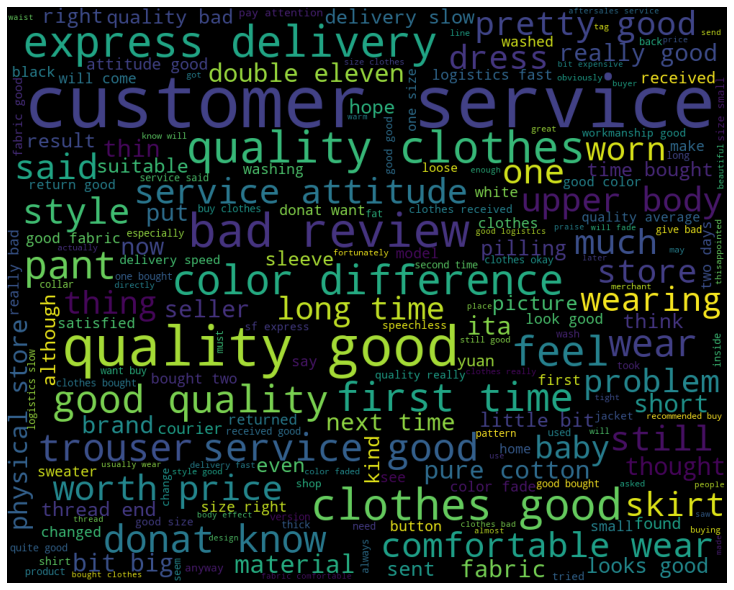

In [ ]:
# Wordcloud For all the reviews
from wordcloud import WordCloud
word_cloud_df = df_sample#[df_sample['sentiment'] == 1]
all_words = ' '.join([text for text in word_cloud_df['reviews']])
 

wordcloud = WordCloud(width = 1000, height = 800, 
                      background_color ='black', 
                      min_font_size = 10, max_font_size = 100).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

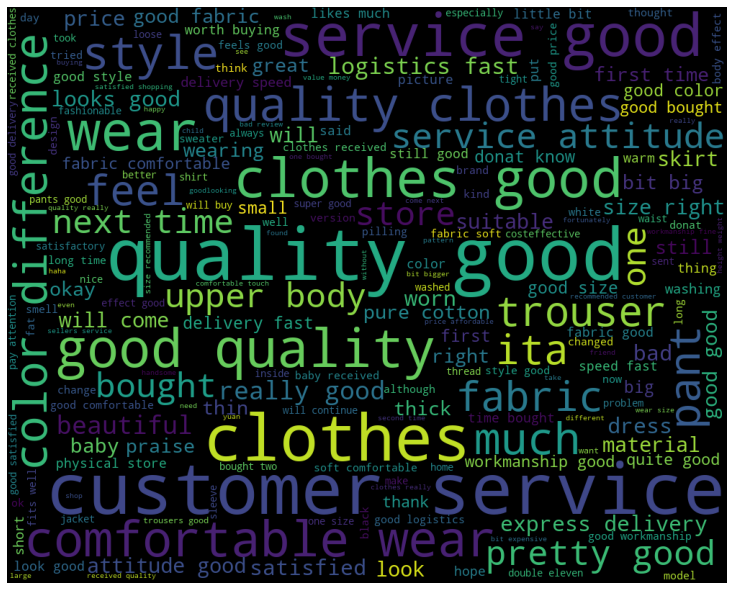

In [ ]:
# Wordcloud for positive reviews
from wordcloud import WordCloud
word_cloud_df = df_sample[df_sample['sentiment'] == 1]
all_words = ' '.join([text for text in word_cloud_df['reviews']])
 

wordcloud = WordCloud(width = 1000, height = 800, 
                      background_color ='black', 
                      min_font_size = 10, max_font_size = 100).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

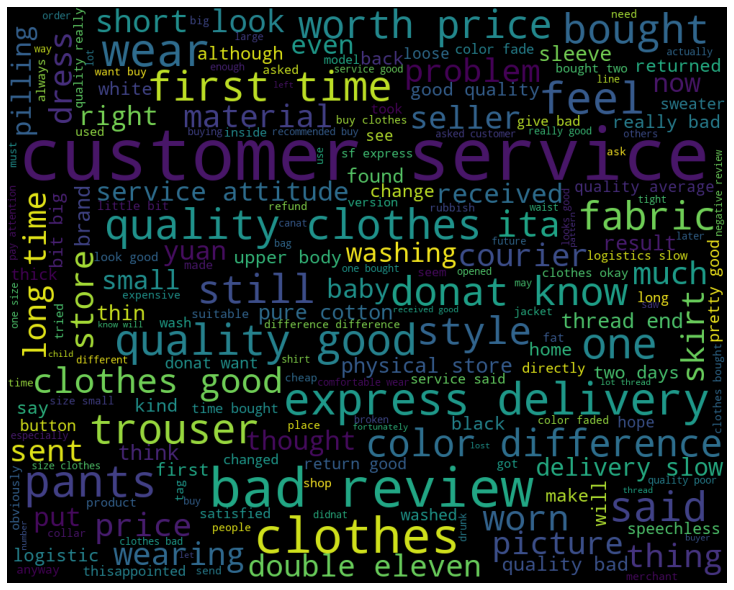

In [ ]:
# Wordcloud for negative reviews
from wordcloud import WordCloud
word_cloud_df = df_sample[df_sample['sentiment'] == 0]
all_words = ' '.join([text for text in word_cloud_df['reviews']])
 

wordcloud = WordCloud(width = 1000, height = 800, 
                      background_color ='black', 
                      min_font_size = 10, max_font_size = 100).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

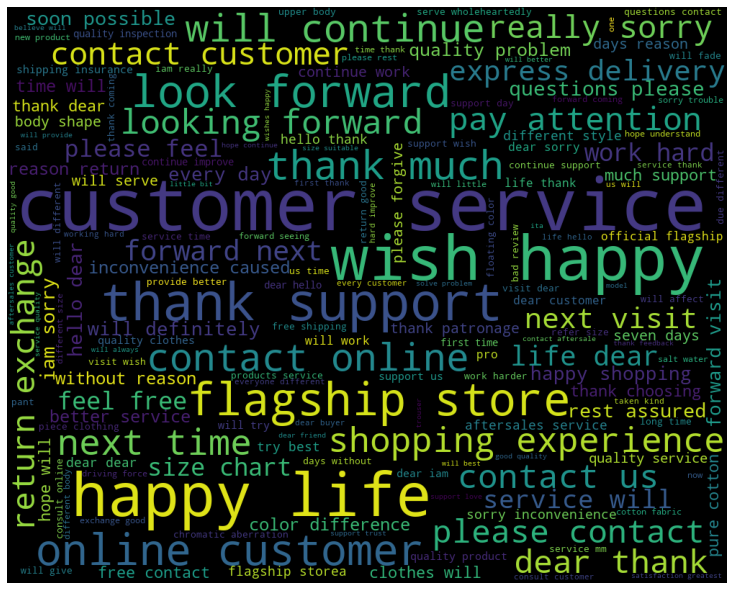

In [ ]:
# Wordcloud for all responses
from wordcloud import WordCloud
word_cloud_df = df_sample
all_words = ' '.join([text for text in word_cloud_df['responses']])
 

wordcloud = WordCloud(width = 1000, height = 800, 
                      background_color ='black', 
                      min_font_size = 10, max_font_size = 100).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

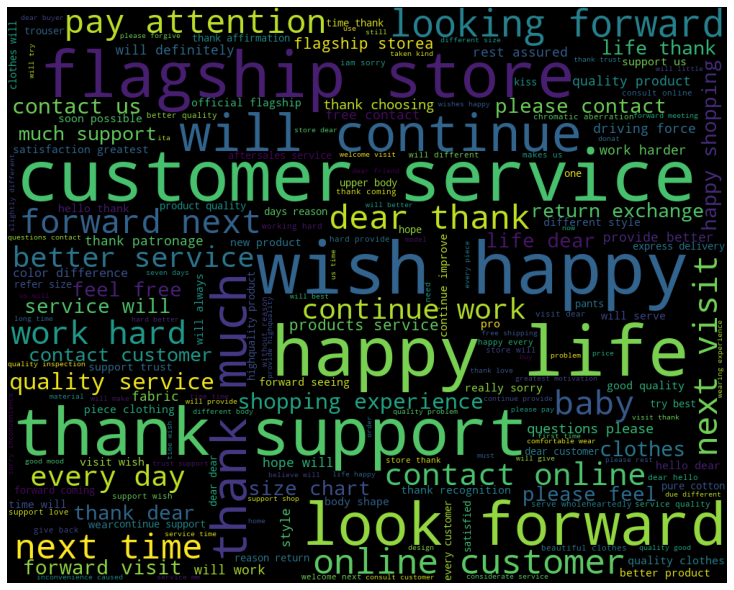

In [ ]:
# Wordcloud for positive responses
from wordcloud import WordCloud
word_cloud_df = df_sample[df_sample['sentiment'] == 1]
all_words = ' '.join([text for text in word_cloud_df['responses']])
 

wordcloud = WordCloud(width = 1000, height = 800, 
                      background_color ='black', 
                      min_font_size = 10, max_font_size = 100).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

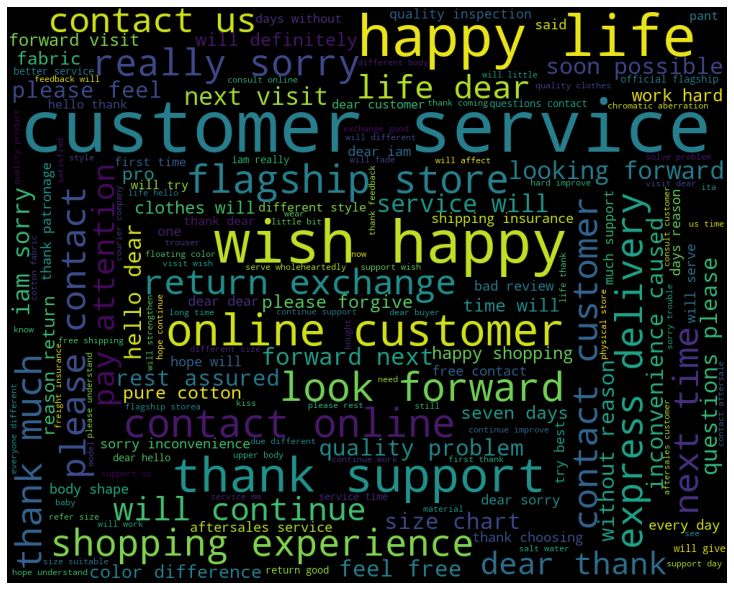

In [ ]:
# Wordcloud for negative reviews
from wordcloud import WordCloud
word_cloud_df = df_sample[df_sample['sentiment'] == 0]
all_words = ' '.join([text for text in word_cloud_df['responses']])
 

wordcloud = WordCloud(width = 1000, height = 800, 
                      background_color ='black', 
                      min_font_size = 10, max_font_size = 100).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## Tokenization

In [11]:
#Finding the length of reviews and responses
df_sample['length_reviews']=df_sample['reviews'].apply(lambda x:len(x.split(" ")))
df_sample['length_responses']=df_sample['responses'].apply(lambda x:len(x.split(" ")))

In [12]:
#filtering reviews and responses less than 70 words.

df_sample = df_sample[df_sample['length_reviews'] <=70]
df_sample = df_sample[df_sample['length_responses'] <=70]

df_sample.shape

(20145, 5)

In [13]:
# Get Review and Response Vocabulary
Review_vocab=set()
for rev in df_sample['reviews']:
    for word in rev.split():
        if word not in Review_vocab:
            Review_vocab.add(word)

Response_vocab=set()
for res in df_sample['responses']:
    for word in res.split():
        if word not in Response_vocab:
            Response_vocab.add(word)

print(len(Review_vocab))
print(len(Response_vocab))

9265
12380


In [14]:
#Max length of reviews and responses
max_rev = max(df_sample['length_reviews'])
max_res = max(df_sample['length_responses'])
max_rev, max_res

(70, 70)

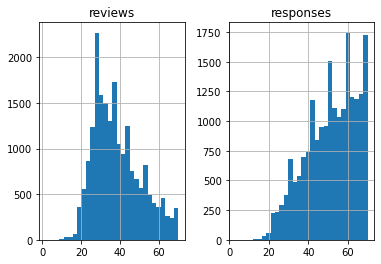

70
70


In [15]:
# hist to visualise the length of reviews and responses
# empty lists
rev = []
res = []

for i in df_sample['reviews']:
      rev.append(len(i.split()))

for i in df_sample['responses']:
      res.append(len(i.split()))

length_df = pd.DataFrame({'reviews':rev, 'responses':res})

length_df.hist(bins = 30)
plt.show()

maxlen_review = np.quantile(length_df['reviews'],1)
print(maxlen_review)

maxlen_response = np.quantile(length_df['responses'],1)
print(maxlen_response)

In [16]:
input_words = sorted(list(Review_vocab))
target_words = sorted(list(Response_vocab))
num_encoder_tokens = len(Review_vocab)
num_decoder_tokens = len(Response_vocab) +1
num_encoder_tokens, num_decoder_tokens

(9265, 12381)

In [17]:
print('Number of samples:', len(df_sample['reviews']))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', maxlen_review)
print('Max sequence length for outputs:', maxlen_response)

Number of samples: 20145
Number of unique input tokens: 9265
Number of unique output tokens: 12381
Max sequence length for inputs: 70
Max sequence length for outputs: 70


In [18]:
#Tokenizing the unique words in review and response vocab. 
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

reverse_input_token_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_token_index = dict((i, word) for word, i in target_token_index.items())

## Data Splitting

In [19]:
#defining X and y
X, y = df_sample[['reviews', 'sentiment']], df_sample['responses']

In [20]:
X['reviews']

index
3                                                                    the clothes are not worn there is a hole in the pocket the quality has not been checked and the quality of more than clothes is not checked
4        kg waist hip i think i should buy it is a little big but i changed it to a smaller one the quality is good and the workmanship is good but i bought the big one it feels a little stretchy and the c...
9        bad bad it is been more than a week the clothes are still confiscated and the bad reviews the customer service lady has bad bad reviews the clothes are not in the right size the bad reviews are no...
12       the clothes are of good quality and very beautiful i canat wait to try them on after receiving the goods the size is right the style is what i like the storeas service is in place the logistics is...
13                                         the quality of the dress is very good there is no color difference the style is very goodlooking it is very suitabl

In [21]:
#Splitting the data for training and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [22]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((16116, 2), (4029, 2), (16116,), (4029,))

In [23]:
# defining the batch for training and encoding the data
def generate_batch(X, y , batch_size):
    X1 = X['reviews']
    X2 = X['sentiment']
    # Generating the batch data
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, maxlen_review),dtype='float32')
            decoder_input_data = np.zeros((batch_size, maxlen_response),dtype='float32')
            decoder_target_data = np.zeros((batch_size, maxlen_response, num_decoder_tokens),dtype='float32')
            sentiment = np.zeros((batch_size,1))
            for i, (input_text, senti, target_text) in enumerate(zip(X1[j:j+batch_size], X2[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()): # encoder input seq
                    encoder_input_data[i, t] = input_token_index[word]
                sentiment[i] = senti 
                for t, word in enumerate(target_text.split()): # decoder input seq
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] 
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, sentiment, decoder_input_data], decoder_target_data)

## Word Embedding

### Glove Embedding

In [24]:
#Implementing word embedding technique - 300 dimension glove to generate dense word vectors 
!pip install gensim
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [25]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_encoder_tokens ,vector_size))
print(gensim_weight_matrix.shape)

gensim_weight_matrix_res = np.zeros((num_decoder_tokens ,vector_size))
print(gensim_weight_matrix_res.shape)

(9265, 300)
(12381, 300)


In [26]:
#Creating the embedding vector
for word, index in input_token_index.items():
    if index < num_encoder_tokens: 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(vector_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


## Encoder Decoder 

In [28]:
#Assigning variables

latent_dim=1024 #No of LSTM Units
embedding_dim = 300  #dimension of the embedding vector
dropout = 0.2

### RNN

#### Encoder & Decoder definition

In [29]:
#Defining the Encoder
encoder_inputs = Input(batch_shape=(None, maxlen_review))
sentiment = Input(batch_shape=(None,1))
enc_emb =  Embedding(num_encoder_tokens, embedding_dim, weights=[gensim_weight_matrix], input_length=maxlen_review, trainable=False, mask_zero = True)
encoder_embedded = enc_emb(encoder_inputs)  

encoder_rnn = SimpleRNN(latent_dim, return_sequences= True, return_state= True, dropout = dropout)
encoder_outputs, state_h = (encoder_rnn)(encoder_embedded)
encoder_states = state_h

In [30]:
# Defining the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(None, None))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim,mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_rnn = SimpleRNN(latent_dim, return_sequences=True, return_state=True, dropout = dropout)
decoder_outputs,_ = decoder_rnn(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Model Definition & Compilation

In [31]:
model = Model([encoder_inputs, sentiment, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 70, 300)      2779500     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 1024)   12678144    ['input_3[0][0]']                
                                                                                              

#### Model Training

In [ ]:
train_samples = len(X_train)
val_samples = len(X_valid)
batch_size = 64
epochs = 20

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/20
251/251 [==============================] - 81s 316ms/step - loss: 3.7728 - accuracy: 0.1795 - val_loss: 2.8961 - val_accuracy: 0.3129
Epoch 2/20
251/251 [==============================] - 78s 312ms/step - loss: 2.5655 - accuracy: 0.3591 - val_loss: 2.3807 - val_accuracy: 0.3942
Epoch 3/20
251/251 [==============================] - 78s 312ms/step - loss: 2.1405 - accuracy: 0.4220 - val_loss: 2.1983 - val_accuracy: 0.4293
Epoch 4/20
251/251 [==============================] - 78s 312ms/step - loss: 1.9034 - accuracy: 0.4593 - val_loss: 2.1081 - val_accuracy: 0.4499
Epoch 5/20
251/251 [==============================] - 78s 312ms/step - loss: 1.7373 - accuracy: 0.4881 - val_loss: 2.0586 - val_accuracy: 0.4640
Epoch 6/20
251/251 [==============================] - 78s 311ms/step - loss: 1.6066 - accuracy: 0.5145 - val_loss: 2.0415 - val_accuracy: 0.4718
Epoch 7/20
251/251 [==============================] - 79s 313ms/step - loss: 1.5007 - accuracy: 0.5375 - val_loss: 2.0379 - val_ac

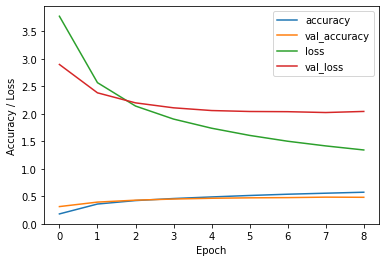

In [ ]:
# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend(loc='upper right')

#### Inference

In [ ]:
#Encoder and Decoder during inference

# Encode the input sequence to get the encoder final states
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
decoder_state_input = Input(shape=(latent_dim,))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h = decoder_rnn(dec_emb2, initial_state=decoder_state_input)
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs, decoder_state_input],
    [decoder_outputs2, state_h])

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 1024)   12678144    ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 simple_rnn_1 (SimpleRNN)       [(None, None, 1024)  2098176     ['embedding_1[1][0]',            
                                , (None, 1024)]                   'input_4[0][0]']          

In [ ]:
def decode_sequence(input_seq):
    # Encode the input and obtain state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq, states_value])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition
        if (sampled_char == '_END' or len(decoded_sentence) > 400):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = h

    return decoded_sentence

#### Evaluation

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predicted Response:', decoded_sentence)

Review: ['the color is beautiful and the golden velvet fabric is also bright and beautiful the material is very drape the quality is good i like it'
 1]
Actual Response: thank you for your appreciation and love every inch of fabric cut is accompanied by sweat we will devote effort and heart to every piece of clothing produced each piece of clothing is our sincere work unique style and belief in nature bolin flagship store i look forward to giving you more surprises if you have any questions please feel free to contact us to answer your questions _END
Predicted Response:  dear thank you for your support to our shop due to the different styles of clothing design the size will be somewhat different it is recommended that you refer to the size chart on the page or consult the online customer service before purchasing and choose the size that is more suitable for you and wear your beauty _END


In [ ]:
k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predic Response:', decoded_sentence)

Review: ['it is okay kilograms fatter size l to ankle size is okay but the waist is a bit big and lose it'
 0]
Actual Response: everyone is unique and their body will naturally be different our clothing styles are versatile and different sizes will be different when you buy you can refer to the page size chart for purchase or consult customer service oh i hope you can also support us a lot _END
Predic Response:  dear thank you for your support to our shop due to the different styles of clothing design the size will be somewhat different it is recommended that you refer to the size chart on the page or consult the online customer service before purchasing and choose the size that is more suitable for you and wear your beauty _END


In [ ]:
import random
train_gen = generate_batch(X_valid, y_valid, batch_size = 1)
review = []
actual = []
predicted = []
for k in random.sample(range(1, len(X_valid)), 500):
  (input_seq, senti, actual_output), _ = next(train_gen)
  decoded_sentence = decode_sequence(input_seq)
  review.append(X_valid[k:k+1].values[0])
  actual.append(y_valid[k:k+1].values[0][7:])
  predicted.append(decoded_sentence)

In [ ]:
for i in random.sample(range(1, len(actual)), 20):
  print(review[i])
  print(actual[i])
  print(predicted[i])

['itas not good at all torn clothes or anything there is no flexibility at all everyone sees it there is no flexibility at all do not buy it in the future'
 0]
dear velvet vest the elasticity of this fabric is very small it is no better than our usual kind of pure cotton vest the fabric is different because of the different elasticity if you do not like it we support the return and exchange for no reason it has caused you trouble sorry _END
 dear thank you for your support to our shop due to the different styles of clothing design the size will be somewhat different it is recommended that you refer to the size chart on the page or consult the online customer service before purchasing and choose the size that is more suitable for you baby is very good i hope to bring you a whole new life experience _END
['the quality can be too long because the ones i bought before were all small so this time i bought the bigger ones and they became a lot bigger'
 1]
dear dear each of our detail pages h

In [ ]:
actual[0:20], predicted[0:20]

(['the logistics belongs to a third party company we cannot control it but we will actively communicate with the express company hoping that the speed can be improved _END',
  'hello i am sorry to trouble you we take the express delivery problem you feedback very seriously and we will negotiate with the express company to improve the problem you mentioned we will continue to improve our overall service quality and we look forward to providing you with better service next time _END',
  'name _END',
  'i am really sorry we have urged the express delivery many times because of the inconvenience caused by the express delivery please understand that as long as the clothes like it _END',
  'hello the fabric is carefully selected by the designer based on this dress which can show the beauty of the design better than other fabrics if you have any questions you can contact our online customer service sancai is looking forward to your visit again _END',
  'dear at the end of the year the logisti

In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

# make a RougeScorer object with rouge_types=['rouge1','rouge2', 'rougeL']
scorer_1 = rouge_scorer.RougeScorer(['rouge1'])
scorer_2 = rouge_scorer.RougeScorer(['rouge2'])
scorer_L = rouge_scorer.RougeScorer(['rougeL'])

# a dictionary that will contain the results
results = {'precision_1': [], 'recall_1': [], 'fmeasure_1': [],
           'precision_2': [], 'recall_2': [], 'fmeasure_2': [],
           'precision_L': [], 'recall_L': [], 'fmeasure_L': []}

# for each of the hypothesis and reference documents pair
for (h, r) in zip(predicted, actual):
    # computing the ROUGE scores and appending it to the lsits
    score_1 = scorer_1.score(h, r)
    score_2 = scorer_2.score(h, r)
    score_L = scorer_L.score(h, r)

    precision, recall, fmeasure = score_1['rouge1']
    results['precision_1'].append(precision)
    results['recall_1'].append(recall)
    results['fmeasure_1'].append(fmeasure)

    precision, recall, fmeasure = score_2['rouge2']
    results['precision_2'].append(precision)
    results['recall_2'].append(recall)
    results['fmeasure_2'].append(fmeasure)

    precision, recall, fmeasure = score_L['rougeL']
    results['precision_L'].append(precision)
    results['recall_L'].append(recall)
    results['fmeasure_L'].append(fmeasure)

print(np.mean(results['precision_1']), np.mean(results['precision_2']), np.mean(results['precision_L']))
print(np.mean(results['recall_1']), np.mean(results['recall_2']), np.mean(results['recall_L']))
print(np.mean(results['fmeasure_1']), np.mean(results['fmeasure_2']), np.mean(results['fmeasure_L']))

0.33812942937185453 0.05842345916001587 0.23069179200288872
0.277457627118644 0.04896551724137931 0.18525423728813556
0.29798214426865477 0.05247836877438555 0.20026784638015283


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
scores = []
for i in range(len(actual)):
  score = sentence_bleu([actual[i].strip().split()], predicted[i].strip().split(), smoothing_function=SmoothingFunction().method4)
  scores.append(score)

bleu_score = np.mean(np.asarray(scores, dtype=np.float32))
bleu_score

0.1277047

### BiRNN

#### Encoder & Decoder definition

In [32]:
#Defining the Encoder
encoder_inputs = Input(batch_shape=(None, maxlen_review))
sentiment = Input(batch_shape=(None,1))
enc_emb =  Embedding(num_encoder_tokens, embedding_dim, weights=[gensim_weight_matrix], input_length=maxlen_review, trainable=False, mask_zero = True)
encoder_embedded = enc_emb(encoder_inputs)  

encoder_birnn = Bidirectional(SimpleRNN(latent_dim, return_sequences= True, return_state= True, dropout = dropout))
encoder_outputs, state_h_fwd, state_h_bwd = (encoder_birnn)(encoder_embedded)
encoder_states = layers.concatenate([state_h_fwd,state_h_bwd])

In [33]:
#Defining the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(None, None))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim,mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_birnn = SimpleRNN(latent_dim * 2, return_sequences=True, return_state=True, dropout = dropout)
decoder_outputs, _ = decoder_birnn(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Model Definition & Compilation

In [34]:
model_birnn = Model([encoder_inputs, sentiment, decoder_inputs], decoder_outputs)

model_birnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_birnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 70, 300)      2779500     ['input_4[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 70, 2048),   2713600     ['embedding_2[0][0]']            
                                 (None, 1024),                                              

#### Model Training

In [ ]:
train_samples = len(X_train) ## dropout = 0.2
val_samples = len(X_valid)
batch_size = 64
epochs = 30

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model_birnn.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/30
251/251 [==============================] - 140s 544ms/step - loss: 3.8887 - accuracy: 0.1661 - val_loss: 2.9695 - val_accuracy: 0.3110
Epoch 2/30
251/251 [==============================] - 136s 540ms/step - loss: 2.6268 - accuracy: 0.3527 - val_loss: 2.4533 - val_accuracy: 0.3892
Epoch 3/30
251/251 [==============================] - 135s 540ms/step - loss: 2.2037 - accuracy: 0.4143 - val_loss: 2.2757 - val_accuracy: 0.4225
Epoch 4/30
251/251 [==============================] - 135s 538ms/step - loss: 1.9469 - accuracy: 0.4528 - val_loss: 2.1976 - val_accuracy: 0.4420
Epoch 5/30
251/251 [==============================] - 134s 536ms/step - loss: 1.7630 - accuracy: 0.4838 - val_loss: 2.1555 - val_accuracy: 0.4541
Epoch 6/30
251/251 [==============================] - 135s 536ms/step - loss: 1.6244 - accuracy: 0.5106 - val_loss: 2.1281 - val_accuracy: 0.4640
Epoch 7/30
251/251 [==============================] - 134s 532ms/step - loss: 1.5112 - accuracy: 0.5336 - val_loss: 2.1218 -

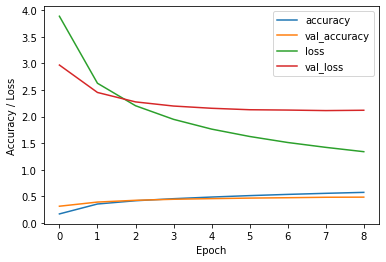

In [ ]:
# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend(loc='upper right')

#### Inference

In [ ]:
#Encoder and Decoder during inference

# Encode the input sequence to get the encoder final states
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
decoder_state_input = Input(shape=(latent_dim * 2,))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h = decoder_birnn(dec_emb2, initial_state=decoder_state_input)
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs, decoder_state_input],
    [decoder_outputs2, state_h])

decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 1024)   12678144    ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 simple_rnn_3 (SimpleRNN)       [(None, None, 2048)  6293504     ['embedding_3[1][0]',            
                                , (None, 2048)]                   'input_8[0][0]']          

In [ ]:
def decode_sequence(input_seq):
    # Encode the input and obtain state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq, states_value])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition
        if (sampled_char == '_END' or len(decoded_sentence) > 400):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = h

    return decoded_sentence

#### Evaluation

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predicted Response:', decoded_sentence)

Review: ['the color is beautiful and the golden velvet fabric is also bright and beautiful the material is very drape the quality is good i like it'
 1]
Actual Response: thank you for your appreciation and love every inch of fabric cut is accompanied by sweat we will devote effort and heart to every piece of clothing produced each piece of clothing is our sincere work unique style and belief in nature bolin flagship store i look forward to giving you more surprises if you have any questions please feel free to contact us to answer your questions _END
Predicted Response:  dear thank you for your support to our shop due to the shooting environment lighting computer monitors and personal understanding of color there may be a slight color difference we have minimized the chromatic aberration problem please contact our customer service to help you solve it _END


In [ ]:
k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predic Response:', decoded_sentence)

Review: ['it is okay kilograms fatter size l to ankle size is okay but the waist is a bit big and lose it'
 0]
Actual Response: everyone is unique and their body will naturally be different our clothing styles are versatile and different sizes will be different when you buy you can refer to the page size chart for purchase or consult customer service oh i hope you can also support us a lot _END
Predic Response:  dear thank you for your support to our shop due to the shooting environment lighting computer monitors and personal understanding of color there may be a slight color difference we have minimized the chromatic aberration problem please contact our customer service to help you solve it _END


In [ ]:
import random
train_gen = generate_batch(X_valid, y_valid, batch_size = 1)
review = []
actual = []
predicted = []
for k in random.sample(range(1, len(X_valid)), 500):
  (input_seq, senti, actual_output), _ = next(train_gen)
  decoded_sentence = decode_sequence(input_seq)
  review.append(X_valid[k:k+1].values[0])
  actual.append(y_valid[k:k+1].values[0][7:])
  predicted.append(decoded_sentence)

In [ ]:
for i in random.sample(range(1, len(actual)), 20):
  print(review[i])
  print(actual[i])
  print(predicted[i])

['the quality of the clothes was too bad so i wore them for a while the thread on the collar was broken and all rotten'
 0]
dear thank you for your feedback you have given us trust and we have not been able to satisfy you very much sorry we have sent additional staff to strictly control the quality and the quality will get better and better if you have any quality problems please contact the customer service package in time to return or exchange _END
 dear thank you for your support to our shop due to the shooting environment lighting computer monitors and personal understanding of color there may be a slight color difference we have minimized the chromatic aberration problem please contact our customer service to help you solve it _END
['very good very good i really like the workmanship such delicate small stitches it looks like a brand'
 1]
thank you for choosing flex flex is an enterprise specializing in making shirts with more than years of offline garment experience and factory sa

#### Evaluation metrics

In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

# make a RougeScorer object with rouge_types=['rouge1','rouge2', 'rougeL']
scorer_1 = rouge_scorer.RougeScorer(['rouge1'])
scorer_2 = rouge_scorer.RougeScorer(['rouge2'])
scorer_L = rouge_scorer.RougeScorer(['rougeL'])

# a dictionary that will contain the results
results = {'precision_1': [], 'recall_1': [], 'fmeasure_1': [],
           'precision_2': [], 'recall_2': [], 'fmeasure_2': [],
           'precision_L': [], 'recall_L': [], 'fmeasure_L': []}

# for each of the hypothesis and reference documents pair
for (h, r) in zip(predicted, actual):
    # computing the ROUGE scores and appending it to the lsits
    score_1 = scorer_1.score(h, r)
    score_2 = scorer_2.score(h, r)
    score_L = scorer_L.score(h, r)

    precision, recall, fmeasure = score_1['rouge1']
    results['precision_1'].append(precision)
    results['recall_1'].append(recall)
    results['fmeasure_1'].append(fmeasure)

    precision, recall, fmeasure = score_2['rouge2']
    results['precision_2'].append(precision)
    results['recall_2'].append(recall)
    results['fmeasure_2'].append(fmeasure)

    precision, recall, fmeasure = score_L['rougeL']
    results['precision_L'].append(precision)
    results['recall_L'].append(recall)
    results['fmeasure_L'].append(fmeasure)

print(np.mean(results['precision_1']), np.mean(results['precision_2']), np.mean(results['precision_L']))
print(np.mean(results['recall_1']), np.mean(results['recall_2']), np.mean(results['recall_L']))
print(np.mean(results['fmeasure_1']), np.mean(results['fmeasure_2']), np.mean(results['fmeasure_L']))

0.28198980881786073 0.054868052315171924 0.1994245453228275
0.29491682785299805 0.05983316481294237 0.20663733075435203
0.2820087859377501 0.05615114670346554 0.1981854546481053


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
scores = []
for i in range(len(actual)):
  score = sentence_bleu([actual[i].strip().split()], predicted[i].strip().split(), smoothing_function=SmoothingFunction().method4)
  scores.append(score)

bleu_score = np.mean(np.asarray(scores, dtype=np.float32))
bleu_score

0.13590118

### LSTM

#### Encoder & Decoder definition

In [35]:
#Defining the Encoder
encoder_inputs = Input(batch_shape=(None, maxlen_review))
sentiment = Input(batch_shape=(None,1))
enc_emb =  Embedding(num_encoder_tokens, embedding_dim, weights=[gensim_weight_matrix], input_length=maxlen_review, trainable=False, mask_zero = True)
encoder_embedded = enc_emb(encoder_inputs)  

encoder_lstm = LSTM(latent_dim, return_state= True, dropout = dropout)
encoder_outputs, state_h, state_c = (encoder_lstm)(encoder_embedded)
encoder_states = [state_h, state_c]

In [36]:
#Defining the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(None, None))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout = dropout)
decoder_outputs,_, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Model Definition & Compilation

In [37]:
model_lstm = Model([encoder_inputs, sentiment, decoder_inputs], decoder_outputs)

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 70, 300)      2779500     ['input_7[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, None, 1024)   12678144    ['input_9[0][0]']                
                                                                                            

#### Model Training

In [ ]:
train_samples = len(X_train) ## dropout = 0.2
val_samples = len(X_valid)
batch_size = 64
epochs = 30

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model_lstm.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/30
251/251 [==============================] - 74s 255ms/step - loss: 3.7278 - accuracy: 0.1671 - val_loss: 3.0124 - val_accuracy: 0.2791
Epoch 2/30
251/251 [==============================] - 62s 244ms/step - loss: 2.7504 - accuracy: 0.3112 - val_loss: 2.5944 - val_accuracy: 0.3423
Epoch 3/30
251/251 [==============================] - 61s 245ms/step - loss: 2.4361 - accuracy: 0.3567 - val_loss: 2.4022 - val_accuracy: 0.3760
Epoch 4/30
251/251 [==============================] - 62s 247ms/step - loss: 2.2439 - accuracy: 0.3867 - val_loss: 2.2858 - val_accuracy: 0.3997
Epoch 5/30
251/251 [==============================] - 62s 245ms/step - loss: 2.1029 - accuracy: 0.4101 - val_loss: 2.2059 - val_accuracy: 0.4157
Epoch 6/30
251/251 [==============================] - 62s 246ms/step - loss: 1.9908 - accuracy: 0.4289 - val_loss: 2.1418 - val_accuracy: 0.4309
Epoch 7/30
251/251 [==============================] - 62s 246ms/step - loss: 1.8973 - accuracy: 0.4458 - val_loss: 2.0977 - val_ac

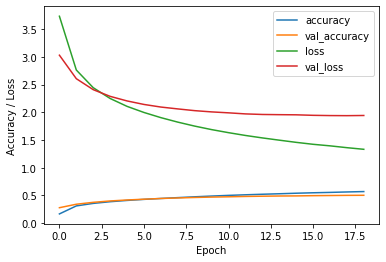

In [ ]:
# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend(loc='upper right')

#### Inference

In [ ]:
#Encoder and Decoder during inference

# Encode the input sequence to get the encoder final states
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

decoder_model.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_68 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_35 (Embedding)       (None, None, 300)    3714300     ['input_68[0][0]']               
                                                                                                  
 input_69 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_70 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                           

In [ ]:
def decode_sequence(input_seq):
    # Encode the input and obtain state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition
        if (sampled_char == '_END' or len(decoded_sentence) > 300):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

#### Evaluation

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predicted Response:', decoded_sentence)

Review: ['the color is beautiful and the golden velvet fabric is also bright and beautiful the material is very drape the quality is good i like it'
 1]
Actual Response: thank you for your appreciation and love every inch of fabric cut is accompanied by sweat we will devote effort and heart to every piece of clothing produced each piece of clothing is our sincere work unique style and belief in nature bolin flagship store i look forward to giving you more surprises if you have any questions please feel free to contact us to answer your questions _END
Predicted Response:  dear thank you for your support to our shop due to the different designs of the product size may be slightly different in size it is recommended that you refer to our product size table in advance when you shop next time or you can consult for sales before wangwang we will serve you attentively i wish


In [ ]:
k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predic Response:', decoded_sentence)

Review: ['it is okay kilograms fatter size l to ankle size is okay but the waist is a bit big and lose it'
 0]
Actual Response: everyone is unique and their body will naturally be different our clothing styles are versatile and different sizes will be different when you buy you can refer to the page size chart for purchase or consult customer service oh i hope you can also support us a lot _END
Predic Response:  dear thank you for your support to our shop due to the different designs of the product size chart different styles will be slightly different in size it is recommended that you consult our online customer service before placing an order you have a happy life _END


In [ ]:
import random
train_gen = generate_batch(X_valid, y_valid, batch_size = 1)
review = []
actual = []
predicted = []
for k in random.sample(range(1, len(X_valid)), 500):
  (input_seq, senti, actual_output), _ = next(train_gen)
  decoded_sentence = decode_sequence(input_seq)
  review.append(X_valid[k:k+1].values[0])
  actual.append(y_valid[k:k+1].values[0][7:])
  predicted.append(decoded_sentence)

In [ ]:
for i in random.sample(range(1, len(actual)), 20):
  print(review[i])
  print(actual[i])
  print(predicted[i])

['the smell is too big after washing it three times it is still the same the designer does not know what to think of this skirt actually uses the button to knock you on the head'
 0]
dear due to the different environmental humidity of production processing warehouse transportation etc there may be a slight smell after opening the package after drying the peculiar smell can slowly thissipate do not expose it to the sun look forward to your next visit _END
 dear thank you for your support to our shop due to the shooting environment lighting computer monitors and personal understanding of color there may be a slight color difference we have minimized the chromatic aberration problem please contact our customer service to help you solve it _END
['i bought a big one but i like it very much the quality is not good the pattern is also good and it is really good and cheap it is worth starting'
 1]
dear thank you for coming thank you for your recognition and satisfaction with our products we wi

#### Evaluation metrics

In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

# make a RougeScorer object with rouge_types=['rouge1','rouge2', 'rougeL']
scorer_1 = rouge_scorer.RougeScorer(['rouge1'])
scorer_2 = rouge_scorer.RougeScorer(['rouge2'])
scorer_L = rouge_scorer.RougeScorer(['rougeL'])

# a dictionary that will contain the results
results = {'precision_1': [], 'recall_1': [], 'fmeasure_1': [],
           'precision_2': [], 'recall_2': [], 'fmeasure_2': [],
           'precision_L': [], 'recall_L': [], 'fmeasure_L': []}

# for each of the hypothesis and reference documents pair
for (h, r) in zip(predicted, actual):
    # computing the ROUGE scores and appending it to the lsits
    score_1 = scorer_1.score(h, r)
    score_2 = scorer_2.score(h, r)
    score_L = scorer_L.score(h, r)

    precision, recall, fmeasure = score_1['rouge1']
    results['precision_1'].append(precision)
    results['recall_1'].append(recall)
    results['fmeasure_1'].append(fmeasure)

    precision, recall, fmeasure = score_2['rouge2']
    results['precision_2'].append(precision)
    results['recall_2'].append(recall)
    results['fmeasure_2'].append(fmeasure)

    precision, recall, fmeasure = score_L['rougeL']
    results['precision_L'].append(precision)
    results['recall_L'].append(recall)
    results['fmeasure_L'].append(fmeasure)

print(np.mean(results['precision_1']), np.mean(results['precision_2']), np.mean(results['precision_L']))
print(np.mean(results['recall_1']), np.mean(results['recall_2']), np.mean(results['recall_L']))
print(np.mean(results['fmeasure_1']), np.mean(results['fmeasure_2']), np.mean(results['fmeasure_L']))

0.2832451496830634 0.05612226464970533 0.19756093558167817
0.29794197292069635 0.060027300303336695 0.20597195357833656
0.28531016992263747 0.05714829606401715 0.19800456152671075


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
scores = []
for i in range(len(actual)):
  score = sentence_bleu([actual[i].strip().split()], predicted[i].strip().split(), smoothing_function=SmoothingFunction().method4)
  scores.append(score)

bleu_score = np.mean(np.asarray(scores, dtype=np.float32))
bleu_score

0.1365672

### Bidirectional LSTM

#### Encoder & Decoder definition

In [38]:
#Defining the Encoder
encoder_inputs = Input(batch_shape=(None, maxlen_review))
sentiment = Input(batch_shape=(None,1))
enc_emb =  Embedding(num_encoder_tokens, embedding_dim, weights=[gensim_weight_matrix], input_length=maxlen_review, trainable=False, mask_zero = True)
encoder_embedded = enc_emb(encoder_inputs)  

encoder_bilstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout= dropout))
encoder_outputs, state_h_fwd, state_c_fwd, state_h_bwd, state_c_bwd = (encoder_bilstm)(encoder_embedded)

state_h = layers.concatenate([state_h_fwd, state_h_bwd])
state_c = layers.concatenate([state_c_fwd, state_c_bwd])
encoder_states = [state_h, state_c]

In [39]:
#Defining the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(None, None))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim,mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_bilstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout= dropout)
decoder_outputs, _, _ = decoder_bilstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Model Definition & Compilation

In [40]:
model_lstm = Model([encoder_inputs, sentiment, decoder_inputs], decoder_outputs)

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_lstm.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 70, 300)      2779500     ['input_10[0][0]']               
                                                                                                  
 input_12 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  [(None, 70, 2048),  10854400    ['embedding_6[0][0]']            
 )                               (None, 1024),                                              

#### Model Training

In [ ]:
train_samples = len(X_train) ## dropout = 0.2
val_samples = len(X_valid)
batch_size = 64
epochs = 30

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model_lstm.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/30
251/251 [==============================] - 115s 410ms/step - loss: 3.3773 - accuracy: 0.2296 - val_loss: 2.6210 - val_accuracy: 0.3451
Epoch 2/30
251/251 [==============================] - 97s 387ms/step - loss: 2.3360 - accuracy: 0.3862 - val_loss: 2.2430 - val_accuracy: 0.4117
Epoch 3/30
251/251 [==============================] - 97s 388ms/step - loss: 1.9961 - accuracy: 0.4400 - val_loss: 2.0823 - val_accuracy: 0.4455
Epoch 4/30
251/251 [==============================] - 97s 388ms/step - loss: 1.7785 - accuracy: 0.4776 - val_loss: 1.9933 - val_accuracy: 0.4675
Epoch 5/30
251/251 [==============================] - 97s 388ms/step - loss: 1.6113 - accuracy: 0.5091 - val_loss: 1.9474 - val_accuracy: 0.4815
Epoch 6/30
251/251 [==============================] - 97s 388ms/step - loss: 1.4719 - accuracy: 0.5391 - val_loss: 1.9094 - val_accuracy: 0.4947
Epoch 7/30
251/251 [==============================] - 97s 388ms/step - loss: 1.3534 - accuracy: 0.5673 - val_loss: 1.8859 - val_a

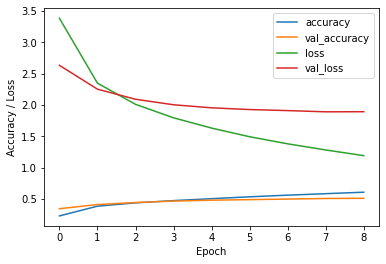

In [ ]:
# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend(loc='upper right')

#### Inference

In [ ]:
#Encoder and Decoder during inference

# Encode the input sequence to get the encoder final states
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
decoder_state_input_h = Input(shape=(latent_dim *2,))
decoder_state_input_c = Input(shape=(latent_dim *2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_bilstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

decoder_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, None, 1024)   12678144    ['input_14[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                            

In [ ]:
def decode_sequence(input_seq):
    # Encode the input and obtain state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition
        if (sampled_char == '_END' or len(decoded_sentence) > 300):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

#### Evaluation

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predicted Response:', decoded_sentence)

Review: ['when i received something it was a bit tricked by the merchant it was obviously paid for plus cashmere what i received was one piece with cashmere and the other without cashmere cannot afford parity'
 0]
Actual Response: please take a look at your order white plus velvet gray xl one with velvet and one without velvet you are not mistaken you can send whatever style you order and what you didnat pay was all plus cash money _END
Predicted Response:  dear the products of the pooh brothers flagship store pursue highquality craftsmanship from the selection of fabrics to the craftsmanship of the garment master we are quite proficient in addition to providing you with highquality products our brand also pays more attention to the quality of service thank


In [ ]:
k+=10
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predic Response:', decoded_sentence)

Review: ['baby received it this is the fourth time i have bought the same style of clothing i like it very much the style is beautiful and impervious the quality is good and the workmanship is good the sagging feeling is good i am really satisfied thank you will cooperate again thank you for express service in place and speed'
 1]
Actual Response: dear thank you for your high evaluation your evaluation has given us all sincere suggestions for beauty mms xinyuquan will also work harder to provide better quality clothes and more considerate services for you i hope to accompany you every day in a good mood i wish you a happy shopping and a happy life xinyuquan clothing is looking forward to your next visit _END
Predic Response:  dear thank you for your support to our shop due to the difference of clothes and personal body shape the size will be different if you feel uncomfortable wearing you can contact us for replacement _END


In [ ]:
import random
train_gen = generate_batch(X_valid, y_valid, batch_size = 1)
review = []
actual = []
predicted = []
for k in random.sample(range(1, len(X_valid)), 500):
  (input_seq, senti, actual_output), _ = next(train_gen)
  decoded_sentence = decode_sequence(input_seq)
  review.append(X_valid[k:k+1].values[0])
  actual.append(y_valid[k:k+1].values[0][7:])
  predicted.append(decoded_sentence)

In [ ]:
actual[10:20], predicted[0:100]

(['dear our styles are all regular sizes it is recommended that you buy according to the size you usually wear please refer to the size chart at the bottom of the page before purchasing to be more accurate if it is not suitable you can within days after signing the receipt contact us for return and exchange we also send shipping insurance _END',
  'i am very sorry for the inconvenience if you have any size questions please feel free to contact online customer service whether it is a presale consultation or a postsale return issue we will handle it for you as soon as possible your satisfaction is our greatest pursuit welcome come again _END',
  'the pants are so handsome good quality the customer service is very patient buy for the second time i will continue to pay attention to it in the future _END',
  'it only takes one minute to meet someone and let you and me meet in the vast crowd this is fate we will repay you with the best quality service choosing us is your wise choice _END',
 

In [ ]:
for i in random.sample(range(1, len(actual)), 20):
  print(review[i])
  print(actual[i])
  print(predicted[i])

#### Evaluation metrics

In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

# make a RougeScorer object with rouge_types=['rouge1','rouge2', 'rougeL']
scorer_1 = rouge_scorer.RougeScorer(['rouge1'])
scorer_2 = rouge_scorer.RougeScorer(['rouge2'])
scorer_L = rouge_scorer.RougeScorer(['rougeL'])

# a dictionary that will contain the results
results = {'precision_1': [], 'recall_1': [], 'fmeasure_1': [],
           'precision_2': [], 'recall_2': [], 'fmeasure_2': [],
           'precision_L': [], 'recall_L': [], 'fmeasure_L': []}

# for each of the hypothesis and reference documents pair
for (h, r) in zip(predicted, actual):
    # computing the ROUGE scores and appending it to the lsits
    score_1 = scorer_1.score(h, r)
    score_2 = scorer_2.score(h, r)
    score_L = scorer_L.score(h, r)

    precision, recall, fmeasure = score_1['rouge1']
    results['precision_1'].append(precision)
    results['recall_1'].append(recall)
    results['fmeasure_1'].append(fmeasure)

    precision, recall, fmeasure = score_2['rouge2']
    results['precision_2'].append(precision)
    results['recall_2'].append(recall)
    results['fmeasure_2'].append(fmeasure)

    precision, recall, fmeasure = score_L['rougeL']
    results['precision_L'].append(precision)
    results['recall_L'].append(recall)
    results['fmeasure_L'].append(fmeasure)

print(np.mean(results['precision_1']), np.mean(results['precision_2']), np.mean(results['precision_L']))
print(np.mean(results['recall_1']), np.mean(results['recall_2']), np.mean(results['recall_L']))
print(np.mean(results['fmeasure_1']), np.mean(results['fmeasure_2']), np.mean(results['fmeasure_L']))

0.24508271959193795 0.049704504381463836 0.1843631700442144
0.2863467698552501 0.059775815909858455 0.21276580161315764
0.25423789521589735 0.05177248827997616 0.18985203591628633


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
scores = []
for i in range(len(actual)):
  score = sentence_bleu([actual[i].strip().split()], predicted[i].strip().split(), smoothing_function=SmoothingFunction().method4)
  scores.append(score)

bleu_score4 = np.mean(np.asarray(scores, dtype=np.float32))
bleu_score4

0.14103898

### Bi directoinal GRU

In [41]:
#Defining the Encoder
encoder_inputs = Input(batch_shape=(None, maxlen_review))
sentiment = Input(batch_shape=(None,1))
enc_emb =  Embedding(num_encoder_tokens, embedding_dim, weights=[gensim_weight_matrix], input_length=maxlen_review, trainable=False, mask_zero = True)
encoder_embedded = enc_emb(encoder_inputs)  

encoder = Bidirectional(GRU(latent_dim,return_sequences=True, return_state=True, dropout=dropout))
encoder_outputs, state_h_fwd, state_h_bwd = encoder(encoder_embedded)

encoder_states = layers.concatenate([state_h_fwd,state_h_bwd])

In [42]:
#Defining the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(None, None))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim,mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_gru = GRU(latent_dim * 2, return_sequences=True, return_state=True, dropout= dropout)
decoder_outputs,_ = decoder_gru(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Model Definition

In [43]:
model = Model([encoder_inputs, sentiment, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 70, 300)      2779500     ['input_13[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  [(None, 70, 2048),  8146944     ['embedding_8[0][0]']            
 )                               (None, 1024),                                              

#### Model Training

In [ ]:
train_samples = len(X_train) ### dropout 0.2
val_samples = len(X_valid)
batch_size = 64
epochs = 15

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/15
251/251 [==============================] - 105s 378ms/step - loss: 2.9999 - accuracy: 0.2972 - val_loss: 2.2721 - val_accuracy: 0.4089
Epoch 2/15
251/251 [==============================] - 91s 363ms/step - loss: 1.9658 - accuracy: 0.4548 - val_loss: 1.9682 - val_accuracy: 0.4750
Epoch 3/15
251/251 [==============================] - 91s 364ms/step - loss: 1.5448 - accuracy: 0.5329 - val_loss: 1.8704 - val_accuracy: 0.5055
Epoch 4/15
251/251 [==============================] - 91s 365ms/step - loss: 1.2293 - accuracy: 0.6053 - val_loss: 1.8528 - val_accuracy: 0.5201
Epoch 5/15
251/251 [==============================] - 91s 364ms/step - loss: 0.9884 - accuracy: 0.6695 - val_loss: 1.8688 - val_accuracy: 0.5269
Epoch 00005: early stopping


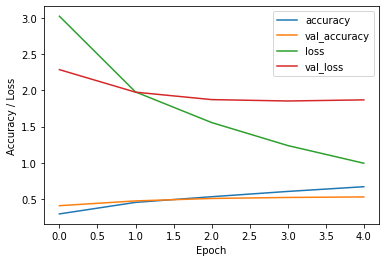

In [ ]:
# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend(loc='upper right')

In [ ]:
model.save_weights('/content/drive/MyDrive/model_weights_BiGRU', save_format = 'h5')
model.save('/content/drive/MyDrive/model_BiGRU', save_format='h5')

#### Bi GRU inference

In [ ]:
#Encoder and Decoder during inference

# Encode the input sequence to get the encoder final states
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
decoder_state_input = Input(shape=(latent_dim *2,))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h = decoder_gru(dec_emb2, initial_state=decoder_state_input)
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs, decoder_state_input],
    [decoder_outputs2, state_h])

decoder_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, None, 1024)   12678144    ['input_19[0][0]']               
                                                                                                  
 input_20 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 gru_1 (GRU)                    [(None, None, 2048)  18886656    ['embedding_9[1][0]',            
                                , (None, 2048)]                   'input_20[0][0]']        

In [ ]:
def decode_sequence(input_seq):
    # Encode the input and obtain state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq, states_value])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition
        if (sampled_char == '_END' or len(decoded_sentence) > 300):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = h

    return decoded_sentence

#### Testing

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0])
print('Predicted Response:', decoded_sentence)

Review: ['the color is beautiful and the golden velvet fabric is also bright and beautiful the material is very drape the quality is good i like it'
 1]
Actual Response: START_ thank you for your appreciation and love every inch of fabric cut is accompanied by sweat we will devote effort and heart to every piece of clothing produced each piece of clothing is our sincere work unique style and belief in nature bolin flagship store i look forward to giving you more surprises if you have any questions please feel free to contact us to answer your questions _END
Predicted Response:  thank you for your support to our shop all the babies sold in the store are all taken in kind and the colors are real however due to the different light angles and contrast there will be some color difference the final color is subject to the actual product i am sorry to cause you trouble i wish you a happy life _END


In [ ]:
k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predic Response:', decoded_sentence)

Review: ['it is okay kilograms fatter size l to ankle size is okay but the waist is a bit big and lose it'
 0]
Actual Response: everyone is unique and their body will naturally be different our clothing styles are versatile and different sizes will be different when you buy you can refer to the page size chart for purchase or consult customer service oh i hope you can also support us a lot _END
Predic Response:  dear thank you for your support to our shop due to the difference of the babys design and the size of the clothes it is recommended that you refer to the size chart or consult the online customer service before purchasing and refer to the size chart on the page or consult the online customer service to recommend a suitable size for you looking forward to your coming again i wish you a happy life _END


In [ ]:
k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predic Response:', decoded_sentence)

Review: ['i bought all the bras and the size of s is only one piece i almost cannot take it off after wearing it it is too tight but this one is just right for you'
 1]
Actual Response: dear hello thank you for your support and love to our loli family if the size of the baby is not appropriate it can be returned to you without affecting the second sale thank you again for your love of lolias house and look forward to your visit again _END
Predic Response:  dear thank you for your support to our shop due to the different styles of clothing design the size will be different it is recommended that you refer to the size chart below or consult the online customer service before purchasing and refer to the size chart on the page before purchasing or consult the online customer service before purchasing i hope you will support it as always and wish you a happy life _END


In [ ]:
import random
train_gen = generate_batch(X_valid, y_valid, batch_size = 1)
review = []
actual = []
predicted = []
for k in random.sample(range(1, len(X_valid)), 500):
  (input_seq, senti, actual_output), _ = next(train_gen)
  decoded_sentence = decode_sequence(input_seq)
  review.append(X_valid[k:k+1].values[0])
  actual.append(y_valid[k:k+1].values[0][7:])
  predicted.append(decoded_sentence)

In [ ]:
for i in random.sample(range(1, len(actual)), 20):
  print(review[i])
  print(actual[i])
  print(predicted[i])

['this is one of the most satisfied tshirts i have ever bought because in this price range the shape is really great the design is very good the print is on the back giving a different feeling and the quality is very good it is recommended that the seller design it you can have a little more chinese style and you will come often in the future full score praise'
 1]
thank you for your suggestion i will develop some chinese style version this is not the best clothes but i want to make the best clothes at this price _END
 dear thank you for your support to our shop due to the different designs of the clothes there are handmeasured size tables for each garment it is recommended to refer to it if it is not suitable you can contact our online customer service to change it for you we will work harder to provide you with more highquality products and services thank you for your support to lolias house and look forward to your next visit _END
['it is okay to receive it but the price is a bit mo

#### Evaluation metrics

In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

# make a RougeScorer object with rouge_types=['rouge1','rouge2', 'rougeL']
scorer_1 = rouge_scorer.RougeScorer(['rouge1'])
scorer_2 = rouge_scorer.RougeScorer(['rouge2'])
scorer_L = rouge_scorer.RougeScorer(['rougeL'])

# a dictionary that will contain the results
results = {'precision_1': [], 'recall_1': [], 'fmeasure_1': [],
           'precision_2': [], 'recall_2': [], 'fmeasure_2': [],
           'precision_L': [], 'recall_L': [], 'fmeasure_L': []}

# for each of the hypothesis and reference documents pair
for (h, r) in zip(predicted, actual):
    # computing the ROUGE scores and appending it to the lsits
    score_1 = scorer_1.score(h, r)
    score_2 = scorer_2.score(h, r)
    score_L = scorer_L.score(h, r)

    precision, recall, fmeasure = score_1['rouge1']
    results['precision_1'].append(precision)
    results['recall_1'].append(recall)
    results['fmeasure_1'].append(fmeasure)

    precision, recall, fmeasure = score_2['rouge2']
    results['precision_2'].append(precision)
    results['recall_2'].append(recall)
    results['fmeasure_2'].append(fmeasure)

    precision, recall, fmeasure = score_L['rougeL']
    results['precision_L'].append(precision)
    results['recall_L'].append(recall)
    results['fmeasure_L'].append(fmeasure)

print(np.mean(results['precision_1']), np.mean(results['precision_2']), np.mean(results['precision_L']))
print(np.mean(results['recall_1']), np.mean(results['recall_2']), np.mean(results['recall_L']))
print(np.mean(results['fmeasure_1']), np.mean(results['fmeasure_2']), np.mean(results['fmeasure_L']))

0.3187270593976751 0.07074061108300057 0.22191876835195404
0.27660865255828176 0.06261805954864849 0.19137551458434093
0.28774334842519705 0.0645810104370691 0.19938156208847682


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
scores = []
for i in range(len(actual)):
  score = sentence_bleu([actual[i].strip().split()], predicted[i].strip().split(), smoothing_function=SmoothingFunction().method4)
  scores.append(score)

bleu_score4 = np.mean(np.asarray(scores, dtype=np.float32))
bleu_score4

0.14032699

### 2 layer Bi GRU

In [44]:
#Defining the Encoder
encoder_inputs = Input(batch_shape=(None, maxlen_review))
sentiment = Input(batch_shape=(None,1))
enc_emb =  Embedding(num_encoder_tokens, embedding_dim, weights=[gensim_weight_matrix], input_length=maxlen_review, trainable=False, mask_zero = True)
encoder_embedded = enc_emb(encoder_inputs)  

encoder_gru, state_h_fwd1, state_h_bwd1 = Bidirectional(GRU(latent_dim, return_sequences= True, return_state= True, dropout=dropout))(encoder_embedded)
encoder_outputs, state_h_fwd, state_h_bwd = Bidirectional(GRU(latent_dim, return_sequences= True, return_state= True, dropout=dropout))(encoder_gru)

encoder_states = layers.concatenate([state_h_fwd,state_h_bwd])

In [45]:
#Defining the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(None, None))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_gru = GRU(latent_dim * 2, return_sequences=True, return_state=True, dropout = dropout)
decoder_outputs,_ = decoder_gru(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Model Definition

In [46]:
model = Model([encoder_inputs, sentiment, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 70, 300)      2779500     ['input_16[0][0]']               
                                                                                                  
 bidirectional_3 (Bidirectional  [(None, 70, 2048),  8146944     ['embedding_10[0][0]']           
 )                               (None, 1024),                                                    
                                 (None, 1024)]                                                    
                                                                                            

#### Model Training

In [ ]:
train_samples = len(X_train) #dropout = 0.2
val_samples = len(X_valid)
batch_size = 64
epochs = 30

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/30
251/251 [==============================] - 194s 695ms/step - loss: 3.3402 - accuracy: 0.2517 - val_loss: 2.7211 - val_accuracy: 0.3443
Epoch 2/30
251/251 [==============================] - 178s 707ms/step - loss: 2.3943 - accuracy: 0.3810 - val_loss: 2.2713 - val_accuracy: 0.4090
Epoch 3/30
251/251 [==============================] - 182s 724ms/step - loss: 1.9660 - accuracy: 0.4496 - val_loss: 2.0344 - val_accuracy: 0.4611
Epoch 4/30
251/251 [==============================] - 181s 723ms/step - loss: 1.6292 - accuracy: 0.5147 - val_loss: 1.9155 - val_accuracy: 0.4945
Epoch 5/30
251/251 [==============================] - 181s 722ms/step - loss: 1.3409 - accuracy: 0.5807 - val_loss: 1.8640 - val_accuracy: 0.5131
Epoch 6/30
251/251 [==============================] - 181s 723ms/step - loss: 1.1014 - accuracy: 0.6433 - val_loss: 1.8624 - val_accuracy: 0.5231
Epoch 7/30
251/251 [==============================] - 181s 722ms/step - loss: 0.9117 - accuracy: 0.6975 - val_loss: 1.8867 -

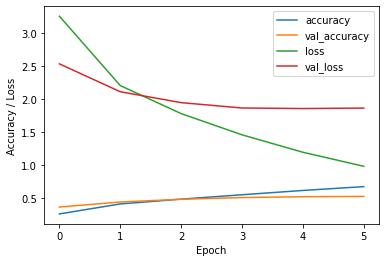

In [ ]:
# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend(loc='upper right')

#### Bi GRU inference

In [ ]:
#Encoder and Decoder during inference

# Encode the input sequence to get the encoder final states
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
decoder_state_input = Input(shape=(latent_dim *2,))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h = decoder_gru(dec_emb2, initial_state=decoder_state_input)
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs, decoder_state_input],
    [decoder_outputs2, state_h])

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 1024)   12678144    ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 gru_5 (GRU)                    [(None, None, 2048)  18886656    ['embedding_3[1][0]',            
                                , (None, 2048)]                   'input_8[0][0]']          

In [ ]:
def decode_sequence(input_seq):
    # Encode the input and obtain state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq, states_value])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition
        if (sampled_char == '_END' or len(decoded_sentence) > 500):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = h

    return decoded_sentence

#### Testing

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0])
print('Predicted Response:', decoded_sentence)

Review: ['the color is beautiful and the golden velvet fabric is also bright and beautiful the material is very drape the quality is good i like it'
 1]
Actual Response: START_ thank you for your appreciation and love every inch of fabric cut is accompanied by sweat we will devote effort and heart to every piece of clothing produced each piece of clothing is our sincere work unique style and belief in nature bolin flagship store i look forward to giving you more surprises if you have any questions please feel free to contact us to answer your questions _END
Predicted Response:  thank you for your support and patronage when you leave a good comment with your finger tap we know that our work has been affirmed i look forward to providing you with better service next time if our products and services are good please recommend to your friends if there is anything unsatisfactory please let us know _END


In [ ]:
k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predic Response:', decoded_sentence)

Review: ['i bought all the bras and the size of s is only one piece i almost cannot take it off after wearing it it is too tight but this one is just right for you'
 1]
Actual Response: dear hello thank you for your support and love to our loli family if the size of the baby is not appropriate it can be returned to you without affecting the second sale thank you again for your love of lolias house and look forward to your visit again _END
Predic Response:  dear dear thank you for your support and love to our shop if the size of the baby is not appropriate it can be returned to you without affecting the second sale thank you again for your love of lolias house and look forward to your visit again _END


In [ ]:
k+=1
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predic Response:', decoded_sentence)

Review: ['it is okay kilograms fatter size l to ankle size is okay but the waist is a bit big and lose it'
 0]
Actual Response: everyone is unique and their body will naturally be different our clothing styles are versatile and different sizes will be different when you buy you can refer to the page size chart for purchase or consult customer service oh i hope you can also support us a lot _END
Predic Response:  dear hello thank you for your support to our shop due to the difference of clothes and personal body shape the size will be different if you feel uncomfortable wearing you can contact us for replacement look forward to your visit again _END


In [ ]:
k+=10
(input_seq, senti, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Review:', X_train[k:k+1].values[0])
print('Actual Response:', y_train[k:k+1].values[0][7:])
print('Predic Response:', decoded_sentence)

Review: ['it is okay the event is a bargain the original price is not worth that much personally i think it will look better in all black with letters printed and it feels yellow i donat know if the clothes have been left for a long time'
 0]
Actual Response: there is a kind of plastic surgery fitness le weiqi insists on using professional fabrics make fashionable sportswear for fitness you can wear fitness clothes on the street wear to work become a new fashion trend le weiqi brings the quality of the big brands directly to everyone and enjoys the priceperformance ratio of the big brands it is not a preliminary selection but a final selection _END
Predic Response:  dear thank you for your support to our shop the quality of the clothes is guaranteed the fabric is soft and comfortable and the quality is guaranteed it is a good helper for scientific parenting your satisfaction is our greatest motivation we will continue to work hard to do better _END


In [ ]:
import random
train_gen = generate_batch(X_valid, y_valid, batch_size = 1)
review = []
actual = []
predicted = []
for k in random.sample(range(1, len(X_valid)), 500):
  (input_seq, senti, actual_output), _ = next(train_gen)
  decoded_sentence = decode_sequence(input_seq)
  review.append(X_valid[k:k+1].values[0])
  actual.append(y_valid[k:k+1].values[0][7:])
  predicted.append(decoded_sentence)

In [ ]:
for i in random.sample(range(1, len(actual)), 20):
  print(review[i])
  print(actual[i])
  print(predicted[i])

['the trousers have a thin layer of fleece which is very elastic i specially bought one size larger according to my usual size and then it became bigger'
 0]
haha this cute model is of regular size and the thicker is the same thickness because the elasticity is good we will be relieved if we wear it and are satisfied thank you for your approval although the transaction is over the service is still continuing it is cold now please keep warm remember not to stay up late be a beautiful fairyran yuchun flagship store q _END
 dear thank you for your support to our shop due to the difference of clothes and personal body shape the size will be different if you feel uncomfortable wearing you can contact us for replacement look forward to your visit again _END
['yes i often buy annels for my children the quality is great if you catch up with thiscounts and do activities the price is even better'
 1]
safe and comfortable buy with confidence insist on making quality with heart and making differen

#### Evaluation metrics

In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

# make a RougeScorer object with rouge_types=['rouge1','rouge2', 'rougeL']
scorer_1 = rouge_scorer.RougeScorer(['rouge1'])
scorer_2 = rouge_scorer.RougeScorer(['rouge2'])
scorer_L = rouge_scorer.RougeScorer(['rougeL'])

# a dictionary that will contain the results
results = {'precision_1': [], 'recall_1': [], 'fmeasure_1': [],
           'precision_2': [], 'recall_2': [], 'fmeasure_2': [],
           'precision_L': [], 'recall_L': [], 'fmeasure_L': []}

# for each of the hypothesis and reference documents pair
for (h, r) in zip(predicted, actual):
    # computing the ROUGE scores and appending it to the lsits
    score_1 = scorer_1.score(h, r)
    score_2 = scorer_2.score(h, r)
    score_L = scorer_L.score(h, r)

    precision, recall, fmeasure = score_1['rouge1']
    results['precision_1'].append(precision)
    results['recall_1'].append(recall)
    results['fmeasure_1'].append(fmeasure)

    precision, recall, fmeasure = score_2['rouge2']
    results['precision_2'].append(precision)
    results['recall_2'].append(recall)
    results['fmeasure_2'].append(fmeasure)

    precision, recall, fmeasure = score_L['rougeL']
    results['precision_L'].append(precision)
    results['recall_L'].append(recall)
    results['fmeasure_L'].append(fmeasure)

print(np.mean(results['precision_1']), np.mean(results['precision_2']), np.mean(results['precision_L']))
print(np.mean(results['recall_1']), np.mean(results['recall_2']), np.mean(results['recall_L']))
print(np.mean(results['fmeasure_1']), np.mean(results['fmeasure_2']), np.mean(results['fmeasure_L']))

0.3209544373500124 0.07887696856755566 0.22647196515689266
0.2789274518686899 0.06983754634577462 0.19729420076159904
0.28658132345576587 0.07094867130168594 0.2022732207212278


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
scores = []
for i in range(len(actual)):
  score = sentence_bleu([actual[i].strip().split()], predicted[i].strip().split(), smoothing_function=SmoothingFunction().method4)
  scores.append(score)

bleu_score = np.mean(np.asarray(scores, dtype=np.float32))
bleu_score

0.1446545

## Further experiments with Bi GRU

### Various train-test ratio

In [ ]:
#Splitting the data for training and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 123)

In [ ]:
latent_dim = 1024
embedding_dim = 300
dropout = 0.2

In [ ]:
#Defining the Encoder
encoder_inputs = Input(batch_shape=(None, maxlen_review))
sentiment = Input(batch_shape=(None,1))
enc_emb =  Embedding(num_encoder_tokens, embedding_dim, weights=[gensim_weight_matrix], input_length=maxlen_review, trainable=False, mask_zero = True)
encoder_embedded = enc_emb(encoder_inputs)  

encoder_gru, state_h_fwd1, state_h_bwd1 = Bidirectional(GRU(latent_dim, return_sequences= True, return_state= True, dropout=dropout))(encoder_embedded)
encoder_outputs, state_h_fwd, state_h_bwd = Bidirectional(GRU(latent_dim, return_sequences= True, return_state= True, dropout=dropout))(encoder_gru)

encoder_states = layers.concatenate([state_h_fwd,state_h_bwd])

In [ ]:
#Defining the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(None, None))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_gru = GRU(latent_dim * 2, return_sequences=True, return_state=True, dropout = dropout)
decoder_outputs,_ = decoder_gru(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Model Definition

In [ ]:
model = Model([encoder_inputs, sentiment, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 70, 300)      2779500     ['input_7[0][0]']                
                                                                                                  
 bidirectional_4 (Bidirectional  [(None, 70, 2048),  8146944     ['embedding_4[0][0]']            
 )                               (None, 1024),                                                    
                                 (None, 1024)]                                                    
                                                                                            

#### Model Training

In [ ]:
train_samples = len(X_train) ## 90-10 train-test
val_samples = len(X_valid)
batch_size = 64
epochs = 30

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/30
283/283 [==============================] - 209s 680ms/step - loss: 3.0357 - accuracy: 0.2890 - val_loss: 2.3020 - val_accuracy: 0.4006
Epoch 2/30
283/283 [==============================] - 195s 686ms/step - loss: 2.0161 - accuracy: 0.4465 - val_loss: 1.9672 - val_accuracy: 0.4728
Epoch 3/30
283/283 [==============================] - 195s 691ms/step - loss: 1.6209 - accuracy: 0.5196 - val_loss: 1.8457 - val_accuracy: 0.5097
Epoch 4/30
283/283 [==============================] - 197s 695ms/step - loss: 1.3285 - accuracy: 0.5841 - val_loss: 1.8091 - val_accuracy: 0.5259
Epoch 5/30
283/283 [==============================] - 196s 693ms/step - loss: 1.1040 - accuracy: 0.6414 - val_loss: 1.8123 - val_accuracy: 0.5364
Epoch 00005: early stopping


In [ ]:
train_samples = len(X_train) ## 85-15 train-test
val_samples = len(X_valid)
batch_size = 64
epochs = 30

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/30
267/267 [==============================] - 196s 677ms/step - loss: 3.2593 - accuracy: 0.2623 - val_loss: 2.5871 - val_accuracy: 0.3569
Epoch 2/30
267/267 [==============================] - 185s 689ms/step - loss: 2.2459 - accuracy: 0.4057 - val_loss: 2.1186 - val_accuracy: 0.4403
Epoch 3/30
267/267 [==============================] - 188s 706ms/step - loss: 1.8089 - accuracy: 0.4837 - val_loss: 1.9237 - val_accuracy: 0.4879
Epoch 4/30
267/267 [==============================] - 189s 707ms/step - loss: 1.4794 - accuracy: 0.5511 - val_loss: 1.8440 - val_accuracy: 0.5143
Epoch 5/30
267/267 [==============================] - 189s 706ms/step - loss: 1.2143 - accuracy: 0.6154 - val_loss: 1.8282 - val_accuracy: 0.5277
Epoch 6/30
267/267 [==============================] - 188s 705ms/step - loss: 1.0098 - accuracy: 0.6699 - val_loss: 1.8495 - val_accuracy: 0.5326
Epoch 00006: early stopping


In [ ]:
train_samples = len(X_train) ## 70-30 train-test
val_samples = len(X_valid)
batch_size = 64
epochs = 30

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/30
220/220 [==============================] - 182s 749ms/step - loss: 3.4286 - accuracy: 0.2387 - val_loss: 2.7629 - val_accuracy: 0.3311
Epoch 2/30
220/220 [==============================] - 169s 763ms/step - loss: 2.4512 - accuracy: 0.3722 - val_loss: 2.2990 - val_accuracy: 0.4027
Epoch 3/30
220/220 [==============================] - 171s 777ms/step - loss: 2.0144 - accuracy: 0.4422 - val_loss: 2.0546 - val_accuracy: 0.4549
Epoch 4/30
220/220 [==============================] - 170s 775ms/step - loss: 1.6813 - accuracy: 0.5046 - val_loss: 1.9348 - val_accuracy: 0.4878
Epoch 5/30
220/220 [==============================] - 171s 776ms/step - loss: 1.3977 - accuracy: 0.5670 - val_loss: 1.8852 - val_accuracy: 0.5071
Epoch 6/30
220/220 [==============================] - 171s 777ms/step - loss: 1.1649 - accuracy: 0.6263 - val_loss: 1.8843 - val_accuracy: 0.5173
Epoch 7/30
220/220 [==============================] - 171s 777ms/step - loss: 0.9788 - accuracy: 0.6782 - val_loss: 1.9029 -

In [ ]:
train_samples = len(X_train) ## 60-40 train-test
val_samples = len(X_valid)
batch_size = 64
epochs = 30

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/30
188/188 [==============================] - 170s 803ms/step - loss: 3.5327 - accuracy: 0.2229 - val_loss: 2.8608 - val_accuracy: 0.3202
Epoch 2/30
188/188 [==============================] - 153s 812ms/step - loss: 2.5567 - accuracy: 0.3563 - val_loss: 2.3909 - val_accuracy: 0.3864
Epoch 3/30
188/188 [==============================] - 158s 843ms/step - loss: 2.1121 - accuracy: 0.4254 - val_loss: 2.1282 - val_accuracy: 0.4404
Epoch 4/30
188/188 [==============================] - 159s 845ms/step - loss: 1.7708 - accuracy: 0.4861 - val_loss: 1.9940 - val_accuracy: 0.4751
Epoch 5/30
188/188 [==============================] - 159s 847ms/step - loss: 1.4780 - accuracy: 0.5469 - val_loss: 1.9313 - val_accuracy: 0.4969
Epoch 6/30
188/188 [==============================] - 160s 850ms/step - loss: 1.2285 - accuracy: 0.6094 - val_loss: 1.9241 - val_accuracy: 0.5072
Epoch 7/30
188/188 [==============================] - 159s 848ms/step - loss: 1.0269 - accuracy: 0.6653 - val_loss: 1.9295 -

### Various LSTM units - 128, 256 & 512

In [ ]:
latent_dim = 512
embedding_dim = 300
dropout = 0.2

In [ ]:
#Defining the Encoder
encoder_inputs = Input(batch_shape=(None, maxlen_review))
sentiment = Input(batch_shape=(None,1))
enc_emb =  Embedding(num_encoder_tokens, embedding_dim, weights=[gensim_weight_matrix], input_length=maxlen_review, trainable=False, mask_zero = True)
encoder_embedded = enc_emb(encoder_inputs)  

encoder_gru, state_h_fwd1, state_h_bwd1 = Bidirectional(GRU(latent_dim, return_sequences= True, return_state= True, dropout=dropout))(encoder_embedded)
encoder_outputs, state_h_fwd, state_h_bwd = Bidirectional(GRU(latent_dim, return_sequences= True, return_state= True, dropout=dropout))(encoder_gru)

encoder_states = layers.concatenate([state_h_fwd,state_h_bwd])

In [ ]:
#Defining the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(None, None))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_gru = GRU(latent_dim * 2, return_sequences=True, return_state=True, dropout = dropout)
decoder_outputs,_ = decoder_gru(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Model Definition

In [ ]:
model = Model([encoder_inputs, sentiment, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 70, 300)      2779500     ['input_14[0][0]']               
                                                                                                  
 bidirectional_8 (Bidirectional  [(None, 70, 1024),  2500608     ['embedding_8[0][0]']            
 )                               (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                            

#### Model Training

In [ ]:
train_samples = len(X_train) #latent dim = 128
val_samples = len(X_valid)
batch_size = 64
epochs = 40

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/40
251/251 [==============================] - 117s 335ms/step - loss: 4.3274 - accuracy: 0.0656 - val_loss: 4.1008 - val_accuracy: 0.0834
Epoch 2/40
251/251 [==============================] - 59s 232ms/step - loss: 3.7966 - accuracy: 0.1401 - val_loss: 3.4698 - val_accuracy: 0.2132
Epoch 3/40
251/251 [==============================] - 60s 237ms/step - loss: 3.1392 - accuracy: 0.2647 - val_loss: 2.9368 - val_accuracy: 0.3031
Epoch 4/40
251/251 [==============================] - 59s 235ms/step - loss: 2.7289 - accuracy: 0.3269 - val_loss: 2.6431 - val_accuracy: 0.3469
Epoch 5/40
251/251 [==============================] - 60s 240ms/step - loss: 2.4714 - accuracy: 0.3646 - val_loss: 2.4596 - val_accuracy: 0.3759
Epoch 6/40
251/251 [==============================] - 59s 237ms/step - loss: 2.2960 - accuracy: 0.3919 - val_loss: 2.3426 - val_accuracy: 0.3975
Epoch 7/40
251/251 [==============================] - 59s 237ms/step - loss: 2.1686 - accuracy: 0.4121 - val_loss: 2.2644 - val_a

In [ ]:
train_samples = len(X_train) #latent dim = 256
val_samples = len(X_valid)
batch_size = 64
epochs = 40

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/40
251/251 [==============================] - 88s 283ms/step - loss: 3.9830 - accuracy: 0.1281 - val_loss: 3.3076 - val_accuracy: 0.2353
Epoch 2/40
251/251 [==============================] - 67s 263ms/step - loss: 2.9041 - accuracy: 0.3018 - val_loss: 2.6532 - val_accuracy: 0.3453
Epoch 3/40
251/251 [==============================] - 67s 265ms/step - loss: 2.4319 - accuracy: 0.3733 - val_loss: 2.3704 - val_accuracy: 0.3907
Epoch 4/40
251/251 [==============================] - 67s 267ms/step - loss: 2.1664 - accuracy: 0.4152 - val_loss: 2.2144 - val_accuracy: 0.4213
Epoch 5/40
251/251 [==============================] - 67s 268ms/step - loss: 1.9828 - accuracy: 0.4456 - val_loss: 2.1188 - val_accuracy: 0.4423
Epoch 6/40
251/251 [==============================] - 67s 269ms/step - loss: 1.8399 - accuracy: 0.4705 - val_loss: 2.0524 - val_accuracy: 0.4596
Epoch 7/40
251/251 [==============================] - 67s 269ms/step - loss: 1.7239 - accuracy: 0.4931 - val_loss: 2.0099 - val_ac

In [ ]:
train_samples = len(X_train) #latent dim = 512
val_samples = len(X_valid)
batch_size = 64
epochs = 40

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 1, restore_best_weights=True)

history = model.fit(generate_batch(X_train, y_train, batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_valid, y_valid, batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=es)

Epoch 1/40
251/251 [==============================] - 110s 372ms/step - loss: 3.5359 - accuracy: 0.2087 - val_loss: 2.8311 - val_accuracy: 0.3177
Epoch 2/40
251/251 [==============================] - 90s 356ms/step - loss: 2.4971 - accuracy: 0.3655 - val_loss: 2.3142 - val_accuracy: 0.4034
Epoch 3/40
251/251 [==============================] - 91s 362ms/step - loss: 2.0654 - accuracy: 0.4358 - val_loss: 2.0901 - val_accuracy: 0.4483
Epoch 4/40
251/251 [==============================] - 91s 363ms/step - loss: 1.7875 - accuracy: 0.4851 - val_loss: 1.9767 - val_accuracy: 0.4773
Epoch 5/40
251/251 [==============================] - 91s 364ms/step - loss: 1.5778 - accuracy: 0.5277 - val_loss: 1.9216 - val_accuracy: 0.4945
Epoch 6/40
251/251 [==============================] - 92s 365ms/step - loss: 1.4105 - accuracy: 0.5657 - val_loss: 1.8896 - val_accuracy: 0.5063
Epoch 7/40
251/251 [==============================] - 92s 366ms/step - loss: 1.2759 - accuracy: 0.5989 - val_loss: 1.8849 - val_a